In [1]:
import numpy as np

import os

from nbodykit.lab import *
from nbodykit import setup_logging, style

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm

/home/jamesdr/.conda/envs/usrp2024/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from baryonification.baryonification.params import par
from baryonification.baryonification.cosmo import cosmo
from baryonification.baryonification.displ import displace
from baryonification.baryonification.halo_displ import displace_haloes

from miniramses.utils.py.miniramses import rd_info
from miniramses.utils.py.miniramses import Info

In [3]:
#initialise parameters
par = par()
par.files.transfct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/CDM_PLANCK_tk.dat"
par.files.cosmofct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/cosmofct.dat"
par.files.displfct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/displfct.dat"
par.files.halofile_format = "ramses"
par.files.partfile_format = "ramses"
par.files.partfile_in = "/home/jamesdr/scratch/miniramses/output_00011"
par.files.partfile_out = "/home/jamesdr/usrp2024/partfile_out.std"
par.files.halofile_in = "/home/jamesdr/scratch/miniramses/output_00011"
par.files.halofile_out = "/home/jamesdr/usrp2024/halofile_out.std"

Found 134217728 particles
Reading particle data...


In [4]:
import re

# Extracting the path using regular expression
path = re.match(r'(.*/miniramses/)', par.files.partfile_in).group(1)

# Extracting the number as an integer
nout = int(re.match(r'.*/output_(\d+)', par.files.partfile_in).group(1))

i = rd_info(nout, path=path)
unit_l = i.unit_l
unit_d = i.unit_d #g/cm^3
unit_m = unit_d * (unit_l)**3.0
unit_m_in_Msol_per_h = unit_m / (1.989e33) * par.cosmo.h0
unit_l_in_Mpc_per_h = unit_l / (3.086e24) * par.cosmo.h0

In [5]:
from baryonification.baryonification.io import read_nbody_file

In [6]:
p_header, non_displaced_particles = read_nbody_file(par)

Found 134217728 particles
Reading particle data...


In [7]:
cosmo(par);

Normalizing power-spectrum done!


In [8]:
displace(par);

Found 134217728 particles
Reading particle data...
N_cpu =  1
building tree..
...done!
Om =  0.27566075
Total number of star particles 0


In [9]:
def read_displaced_particles(file):

    Lbox   = unit_l / (3.086e24) * par.cosmo.h0
    N_chunk = 1
    L_chunk = Lbox/N_chunk
    
    Om = i.omega_m
    z = par.cosmo.z

    f = open(file, 'r')

    #header
    p_header_dt = np.dtype([('a','>d'),('Npart','>i'),('dim','>i'),('Ngas','>i'),('Ndm','>i'),('Nstar','>i'),('buffer','>i')])
    p_header = np.fromfile(f, dtype=p_header_dt, count=1, sep='')
    
    #particles
    p_dt = np.dtype([('mass','>f'),("x",'>f'),("y",'>f'),("z",'>f'),("vx",'>f'),("vy",'>f'),("vz",'>f'),("eps",'>f'),("phi",'>f')])
    p_dm = np.fromfile(f, dtype=p_dt, count=int(p_header['Npart']), sep='')

    #convert to Mpc/h
    p_dm['x']=Lbox*(p_dm['x']+0.5)
    p_dm['y']=Lbox*(p_dm['y']+0.5)
    p_dm['z']=Lbox*(p_dm['z']+0.5)

    #convert to Mstar/h
    print("Om = ", np.sum(p_dm['mass']))
    p_dm['mass'] = p_dm['mass'] * 2.776e11*(Om*(1.0+z)**3.0 + (1.0-Om))/(1.0+z)**3.0 *Lbox**3
        
    print('Reading tipsy-file done!')
    
    #split particles into chunks
    p_dm_list   = []
    for x_min in np.linspace(0,Lbox-L_chunk,N_chunk):
        x_max = x_min + L_chunk
        if (x_max == Lbox):
            x_max = 1.00001*x_max
        for y_min in np.linspace(0,Lbox-L_chunk,N_chunk):
            y_max =y_min + L_chunk
            if (y_max == Lbox):
                    y_max = 1.00001*y_max
            for z_min in np.linspace(0,Lbox-L_chunk,N_chunk):
                z_max = z_min + L_chunk
                if (z_max == Lbox):
                        z_max = 1.00001*z_max
                ID_dm = np.where((p_dm['x']>=x_min) & (p_dm['x']<x_max) & (p_dm['y']>=y_min) & (p_dm['y']<y_max) & (p_dm['z']>=z_min) & (p_dm['z']<z_max))
                p_dm_list += [p_dm[ID_dm]]
    
    return p_header, p_dm_list

In [10]:
p_displaced_header, displaced_particles = read_displaced_particles("/home/jamesdr/usrp2024/partfile_out.std")

Om =  0.27566075
Reading tipsy-file done!


In [11]:
plt.style.use(style.notebook)

In [12]:
setup_logging()

In [13]:
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog({'Position' : np.vstack((non_displaced_particles[0]['x'],non_displaced_particles[0]['y'],non_displaced_particles[0]['z'])).T})

In [14]:
# convert to a MeshSource, using TSC interpolation on 256^3 mesh
mesh = cat.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position')

/tmp/ipykernel_2995215/3617874095.py:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(window='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position')


In [15]:
# compute the power, specifying desired linear k-binning
r = FFTPower(mesh, mode='1d', dk=0.05, kmin=0.05)

[ 000011.72 ]   0: 07-24 13:07  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 134217728 
[ 000016.77 ]   0: 07-24 13:07  CatalogMesh     INFO     painted 4194304 out of 134217728 objects to mesh
[ 000016.77 ]   0: 07-24 13:07  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 134217728 
[ 000019.20 ]   0: 07-24 13:07  CatalogMesh     INFO     painted 8388608 out of 134217728 objects to mesh
[ 000019.20 ]   0: 07-24 13:07  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 134217728 
[ 000021.65 ]   0: 07-24 13:07  CatalogMesh     INFO     painted 12582912 out of 134217728 objects to mesh
[ 000021.65 ]   0: 07-24 13:07  CatalogMesh     INFO     Chunk 12582912 ~ 16777216 / 134217728 
[ 000024.11 ]   0: 07-24 13:07  CatalogMesh     INFO     painted 16777216 out of 134217728 objects to mesh
[ 000024.11 ]   0: 07-24 13:07  CatalogMesh     INFO     Chunk 16777216 ~ 20971520 / 134217728 
[ 000026.55 ]   0: 07-24 13:07  CatalogMesh     INFO     painted 20971520 out of 134217728 objects to mes

In [16]:
# the result is stored at "power" attribute
Pk = r.power
print(Pk)

<BinnedStatistic: dims: (k: 642), variables: ('k', 'power', 'modes')>


Text(0, 0.5, '$P(k)$ [$h^{-3}\\mathrm{Mpc}^3$]')

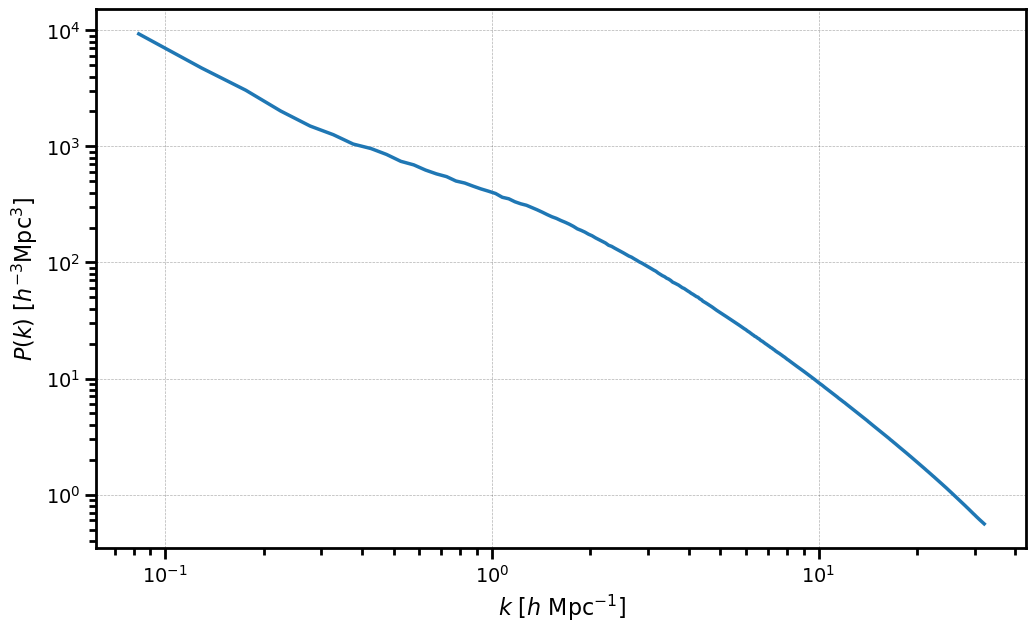

In [17]:
# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")

In [18]:
displaced_cat = ArrayCatalog({'Position' : np.vstack((displaced_particles[0]['x'],displaced_particles[0]['y'],displaced_particles[0]['z'])).T})

In [19]:
# convert to a MeshSource, using TSC interpolation on 256^3 mesh
displaced_mesh = displaced_cat.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position')

/tmp/ipykernel_2995215/3608236483.py:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  displaced_mesh = displaced_cat.to_mesh(window='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position')


In [20]:
# compute the power, specifying desired linear k-binning
displaced_r = FFTPower(displaced_mesh, mode='1d', dk=0.05, kmin=0.05)

[ 000621.54 ]   0: 07-24 13:17  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 134217728 
[ 000623.90 ]   0: 07-24 13:17  CatalogMesh     INFO     painted 4194304 out of 134217728 objects to mesh
[ 000623.90 ]   0: 07-24 13:17  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 134217728 
[ 000626.21 ]   0: 07-24 13:17  CatalogMesh     INFO     painted 8388608 out of 134217728 objects to mesh
[ 000626.21 ]   0: 07-24 13:17  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 134217728 
[ 000628.55 ]   0: 07-24 13:17  CatalogMesh     INFO     painted 12582912 out of 134217728 objects to mesh
[ 000628.55 ]   0: 07-24 13:17  CatalogMesh     INFO     Chunk 12582912 ~ 16777216 / 134217728 
[ 000630.90 ]   0: 07-24 13:17  CatalogMesh     INFO     painted 16777216 out of 134217728 objects to mesh
[ 000630.90 ]   0: 07-24 13:17  CatalogMesh     INFO     Chunk 16777216 ~ 20971520 / 134217728 
[ 000633.23 ]   0: 07-24 13:17  CatalogMesh     INFO     painted 20971520 out of 134217728 objects to mes

In [21]:
# the result is stored at "power" attribute
displaced_Pk = displaced_r.power
print(displaced_Pk)

<BinnedStatistic: dims: (k: 642), variables: ('k', 'power', 'modes')>


Text(0, 0.5, '$P(k)$ [$h^{-3}\\mathrm{Mpc}^3$]')

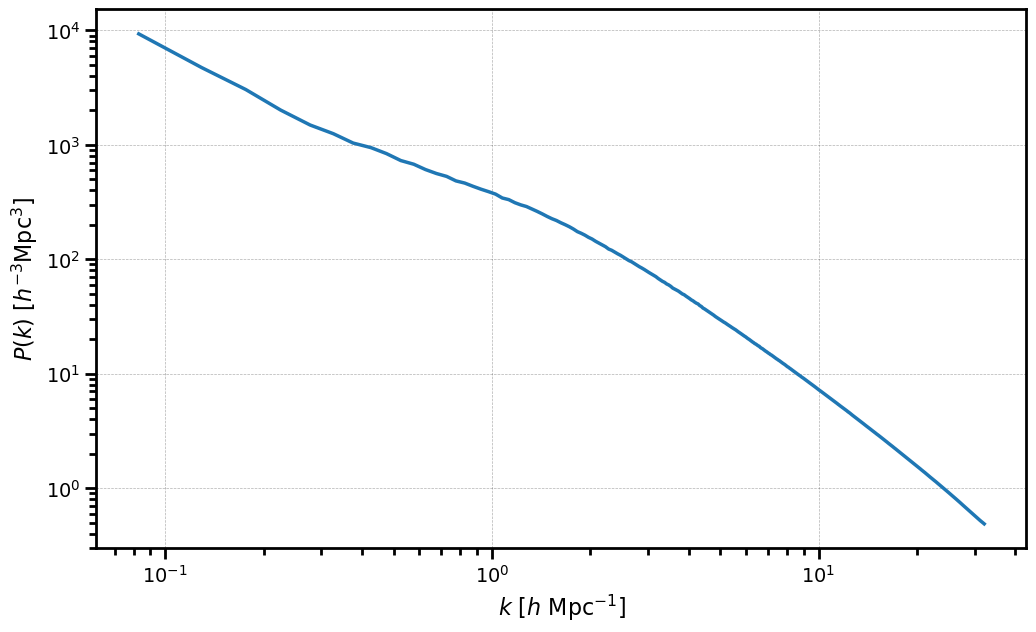

In [22]:
# print the shot noise subtracted P(k)
plt.loglog(displaced_Pk['k'], displaced_Pk['power'].real - displaced_Pk.attrs['shotnoise'])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")

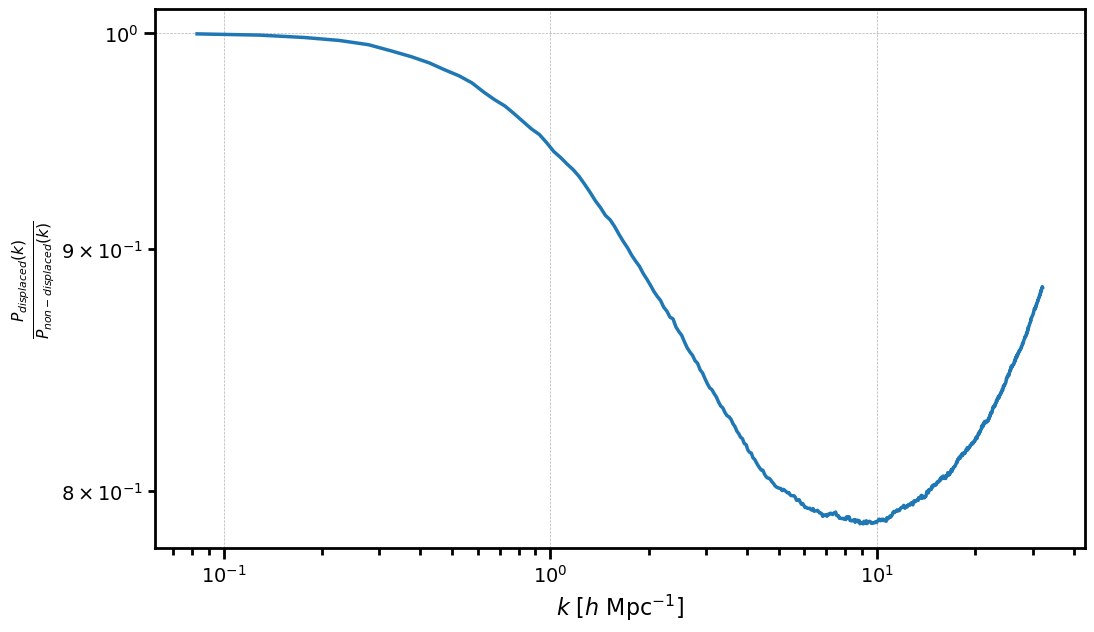

In [23]:
ratio = np.nan_to_num(displaced_Pk['power'].real/Pk['power'].real);

# print the shot noise subtracted P(k)
plt.loglog(displaced_Pk['k'], ratio);

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]");
plt.ylabel(r"$\frac{P_{displaced}(k)}{P_{non-displaced}(k)}$");

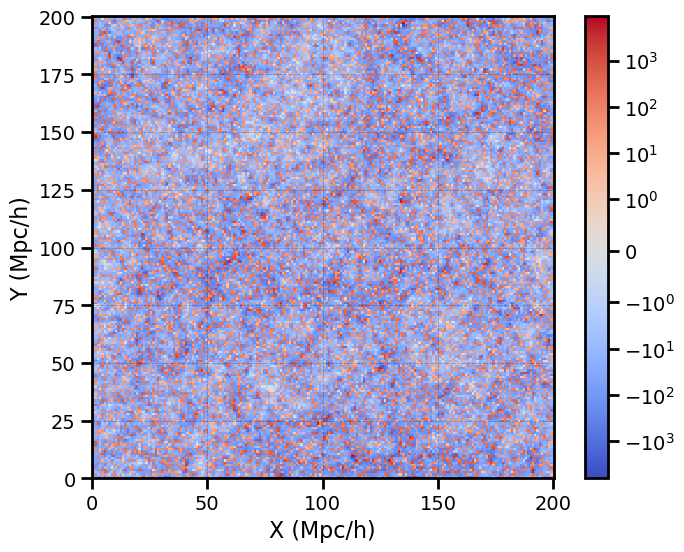

In [24]:
non_displaced_hist, non_displaced_xedges, non_displaced_yedges = np.histogram2d(non_displaced_particles[0]['x'],non_displaced_particles[0]['y'], bins=200)
non_displaced_hist = non_displaced_hist.T

displaced_hist, displaced_xedges, displaced_yedges = np.histogram2d(displaced_particles[0]['x'],displaced_particles[0]['y'], bins=200)
displaced_hist = displaced_hist.T

difference = non_displaced_hist - displaced_hist

norm = SymLogNorm(linthresh=1.0, linscale=1.0, vmin=np.min(difference), vmax=np.max(difference))

# Plotting in log-log scale
plt.figure(figsize=(8, 6))
plt.imshow(difference, interpolation='nearest', origin='lower', extent=[displaced_xedges[0], displaced_xedges[-1], displaced_yedges[0], displaced_yedges[-1]], norm = norm, cmap='coolwarm')

# Add colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('X (Mpc/h)')
plt.ylabel('Y (Mpc/h)')

plt.show()
# plt.savefig('Displacement_Map_200.png', bbox_inches='tight')